In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df = pd.read_csv("bank-full.csv", sep=";")
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [2]:

# 1. Show basic info
df.info()

# 2. Check missing values
df.isnull().sum()

# 3. Drop duplicates
df = df.drop_duplicates()

# 4. Standardize column names
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# 5. Convert data types if needed (example: age to int)
df['age'] = df['age'].astype(int)

df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [3]:


# Target to numeric (point-biserial-friendly)
df["y"] = df["y"].map({"yes": 1, "no": 0}).astype("int8")

# Make categorical columns explicit + normalized lowercase
cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
for c in cat_cols:
    df[c] = df[c].astype(str).str.lower().astype("category")

# Booleanize default/housing/loan
df["default_bool"] = (df["default"].cat.codes == df["default"].cat.categories.tolist().index("yes")).astype("int8")
df["housing_bool"] = (df["housing"].cat.codes == df["housing"].cat.categories.tolist().index("yes")).astype("int8")
df["loan_bool"] = (df["loan"].cat.codes == df["loan"].cat.categories.tolist().index("yes")).astype("int8")

# Contact history flags
df["never_contacted"] = (df["pdays"] == -1).astype("int8")
df["previously_contacted"] = (df["pdays"] != -1).astype("int8")
df["had_prev_contacts"] = (df["previous"] > 0).astype("int8")

# pdays: keep raw, plus a cleaned version for numeric work (NaN for -1)
df["pdays_clean"] = df["pdays"].where(df["pdays"] != -1, np.nan)

# Balance winsorization
low, high = df["balance"].quantile([0.01, 0.99])
df["balance_winz"] = df["balance"].clip(lower=low, upper=high)

# Age to numeric int
df["age"] = df["age"].astype("int16")

# Dataset overview
print("Shape:", df.shape)
print("Nulls:\n", df.isna().sum().sort_values(ascending=False).head(10))

# Calculate percentages
no_percentage = (df['y'].value_counts(normalize=True)[0] * 100).round(2)
yes_percentage = (df['y'].value_counts(normalize=True)[1] * 100).round(2)
print(f"No Percentage: {no_percentage}%")
print(f"Yes Percentage: {yes_percentage}%")

# Analyze the top of the distribution
top_balance = df["balance_winz"].max()
print(f"Top of Winsorized Balance Distribution: {top_balance}")

Shape: (45211, 25)
Nulls:
 pdays_clean             36954
age                         0
pdays                       0
had_prev_contacts           0
previously_contacted        0
never_contacted             0
loan_bool                   0
housing_bool                0
default_bool                0
y                           0
dtype: int64
No Percentage: 88.3%
Yes Percentage: 11.7%
Top of Winsorized Balance Distribution: 13164.900000000001


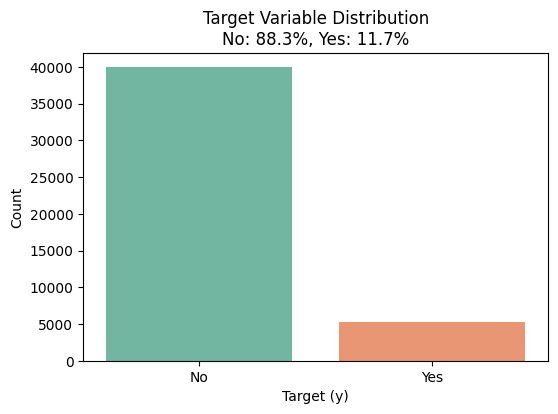

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x="y", data=df, hue="y", palette="Set2", legend=False)
plt.title(f"Target Variable Distribution\nNo: {no_percentage}%, Yes: {yes_percentage}%")
plt.xlabel("Target (y)")
plt.ylabel("Count")
plt.xticks([0, 1], ["No", "Yes"])
plt.show()

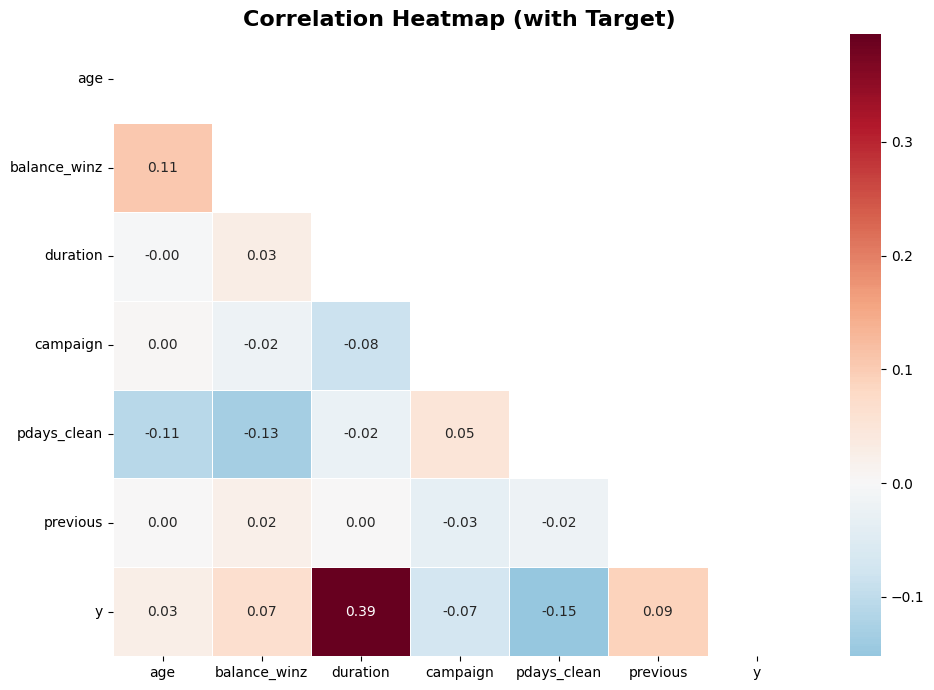

In [5]:
num_cols = ["age", "balance_winz", "duration", "campaign", "pdays_clean", "previous"]
corr = df[num_cols + ["y"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 7))
sns.heatmap(corr, mask=mask, cmap="RdBu_r", annot=True, fmt=".2f", center=0, linewidths=0.5)
plt.title("Correlation Heatmap (with Target)", fontsize=16, weight="bold")
plt.tight_layout()
plt.show()


Contact history comparison:
                               Group  Total  Successes  Success Rate (%)
0        Never contacted (pdays=-1)  36954       3384              9.16
1  Previously contacted (pdays!=-1)   8257       1905             23.07


/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/2025791152.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x="Group", y="Success Rate (%)", data=compare, palette="Set2")


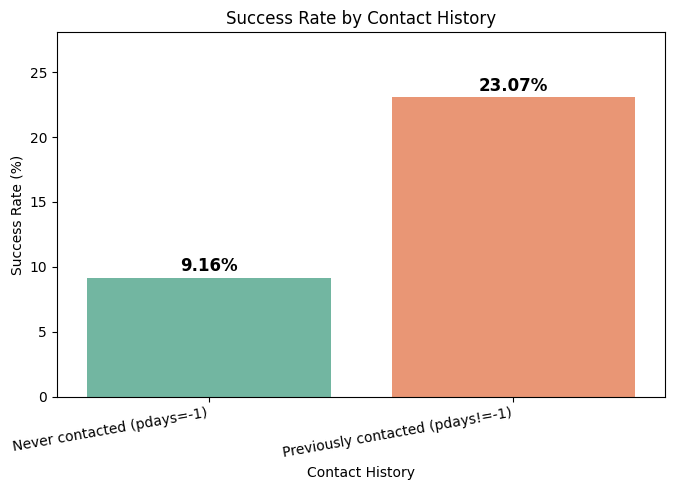

In [6]:
seg = []
for name, mask in {
    "Never contacted (pdays=-1)": (df["never_contacted"] == 1),
    "Previously contacted (pdays!=-1)": (df["previously_contacted"] == 1),
}.items():
    sub = df[mask]
    seg.append({
        "Group": name,
        "Total": len(sub),
        "Successes": int(sub["y"].sum()),
        "Success Rate (%)": round(100 * sub["y"].mean(), 2)
    })

compare = pd.DataFrame(seg)
print("\nContact history comparison:\n", compare)

plt.figure(figsize=(7, 5))
bars = sns.barplot(x="Group", y="Success Rate (%)", data=compare, palette="Set2")
for i, v in enumerate(compare["Success Rate (%)"]):
    bars.text(i, v + 0.5, f"{v}%", ha='center', fontsize=12, weight='bold')
plt.title("Success Rate by Contact History")
plt.ylabel("Success Rate (%)")
plt.xlabel("Contact History")
plt.xticks(rotation=10, ha="right")
plt.ylim(0, compare["Success Rate (%)"].max() + 5)
plt.tight_layout()
plt.show()

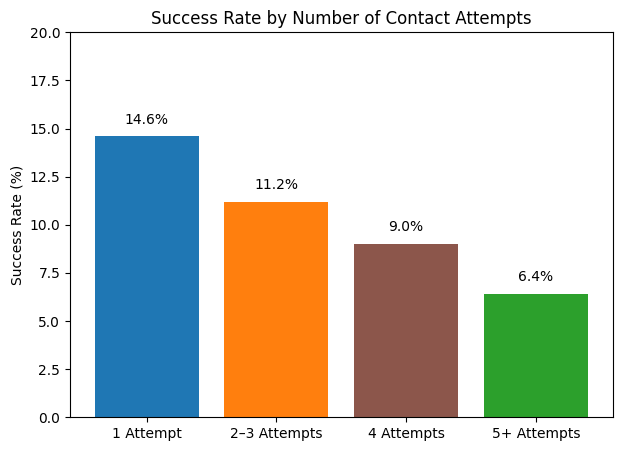

In [7]:
def campaign_bin(x):
    if x == 1:
        return "1 Attempt"
    elif x in [2, 3]:
        return "2–3 Attempts"
    elif x >= 5:
        return "5+ Attempts"
    else:
        return "4 Attempts"

df["campaign_bin"] = df["campaign"].apply(campaign_bin)

success_rates = (
    df.groupby("campaign_bin")["y"]
    .mean()
    .reindex(["1 Attempt", "2–3 Attempts", "4 Attempts", "5+ Attempts"])
    .mul(100)
)

plt.figure(figsize=(7, 5))
bars = plt.bar(success_rates.index, success_rates.values, color=["#1f77b4", "#ff7f0e", "#8c564b", "#2ca02c"])
plt.title("Success Rate by Number of Contact Attempts")
plt.ylabel("Success Rate (%)")
plt.ylim(0, 20)

for bar, rate in zip(bars, success_rates.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f"{rate:.1f}%", ha='center', va='bottom')
plt.show()

/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/3721124481.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  balance_success = df.groupby(pd.qcut(df["balance_winz"], q=5))["y"].mean().mul(100).reset_index()
/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/3721124481.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="balance_winz", y="y", data=balance_success, palette="Spectral")


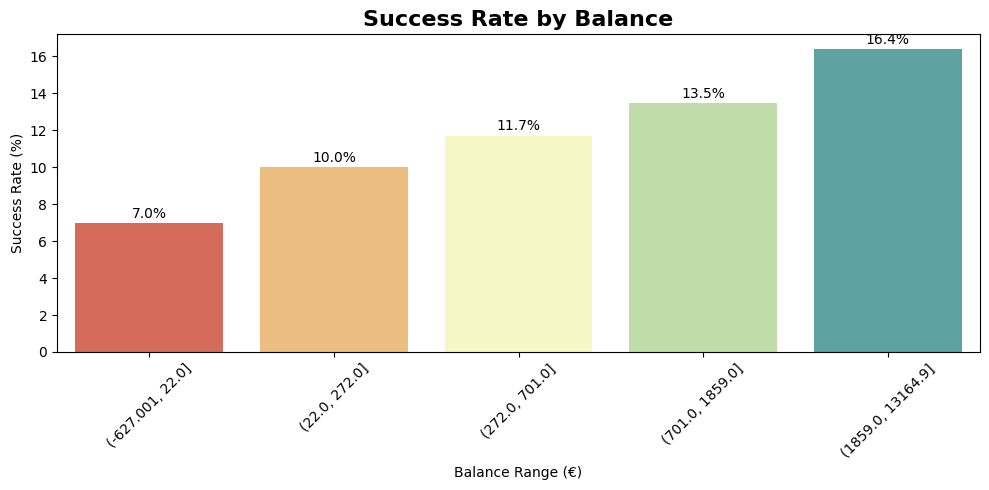

In [8]:
balance_success = df.groupby(pd.qcut(df["balance_winz"], q=5))["y"].mean().mul(100).reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x="balance_winz", y="y", data=balance_success, palette="Spectral")
plt.title("Success Rate by Balance", fontsize=16, weight="bold")
plt.ylabel("Success Rate (%)")
plt.xlabel("Balance Range (€)")
plt.xticks(rotation=45)
for i, row in balance_success.iterrows():
    plt.text(i, row["y"] + 0.3, f"{row['y']:.1f}%", ha="center")
plt.tight_layout()
plt.show()

/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/1340711264.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  housing_success = df.groupby("housing")["y"].mean().reset_index()
/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/1340711264.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="housing", y="y", data=housing_success, palette="Set3")


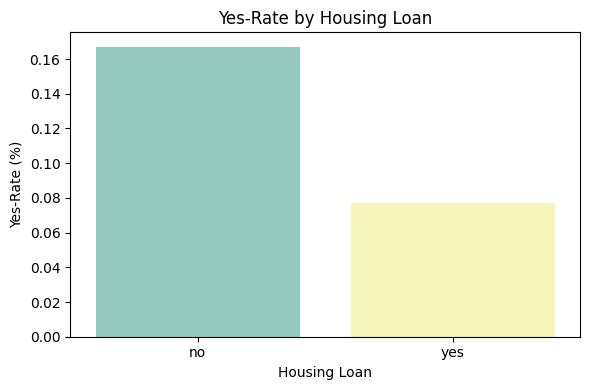

/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/1340711264.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_success = df.groupby("loan")["y"].mean().reset_index()
/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/1340711264.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="loan", y="y", data=loan_success, palette="Set1")


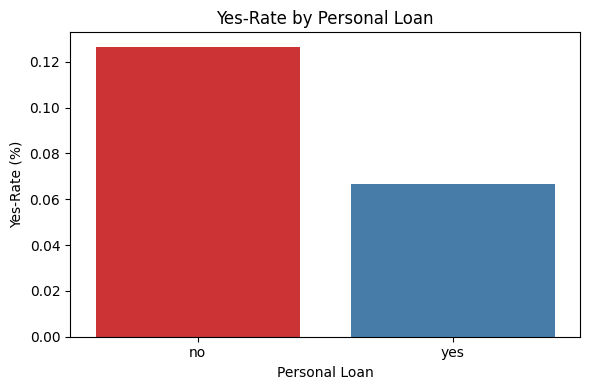

In [9]:
# Housing Loan
housing_success = df.groupby("housing")["y"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="housing", y="y", data=housing_success, palette="Set3")
plt.title("Yes-Rate by Housing Loan")
plt.xlabel("Housing Loan")
plt.ylabel("Yes-Rate (%)")
plt.tight_layout()
plt.show()

# Personal Loan
loan_success = df.groupby("loan")["y"].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(x="loan", y="y", data=loan_success, palette="Set1")
plt.title("Yes-Rate by Personal Loan")
plt.xlabel("Personal Loan")
plt.ylabel("Yes-Rate (%)")
plt.tight_layout()
plt.show()

/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/162376320.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_success = df.groupby("month")["y"].mean().rename("Success Rate (%)").reset_index()
/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/162376320.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="month", y="Success Rate (%)", data=month_success, palette="Set3")


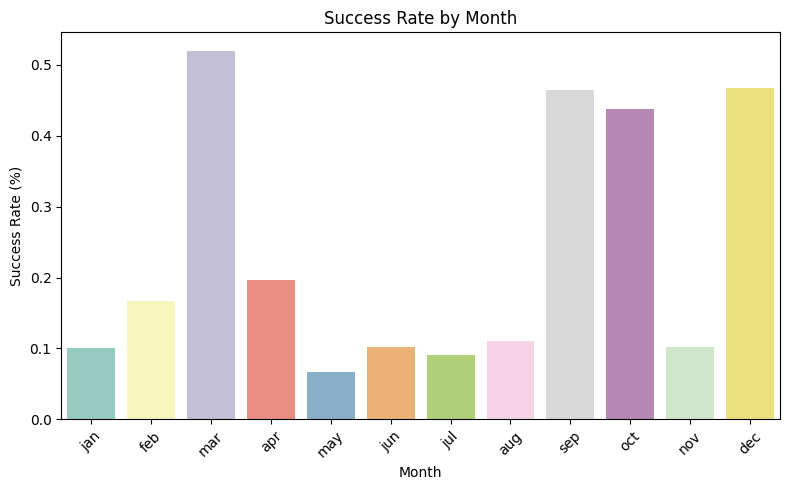

In [10]:
month_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
df["month"] = pd.Categorical(df["month"], categories=month_order, ordered=True)

month_success = df.groupby("month")["y"].mean().rename("Success Rate (%)").reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="month", y="Success Rate (%)", data=month_success, palette="Set3")
plt.title("Success Rate by Month")
plt.xlabel("Month")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/var/folders/wg/yb071g0d6d3g_5kkk64d2klw0000gp/T/ipykernel_78621/870860865.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="day", y="yes_rate", data=by_day, palette="coolwarm")


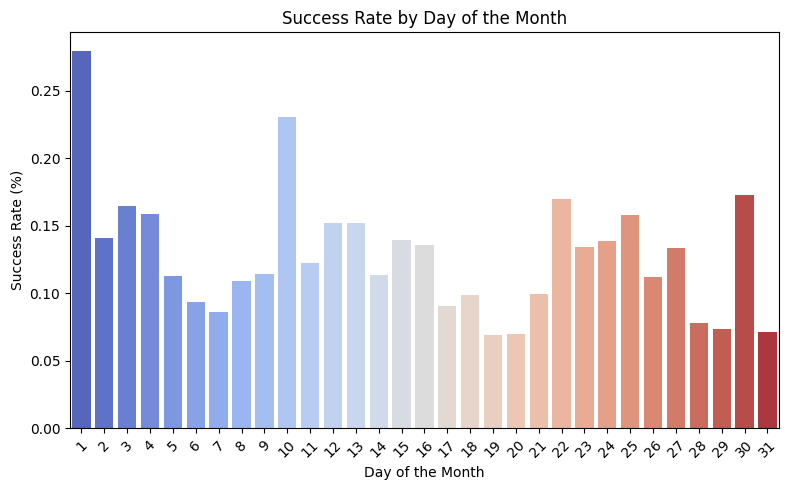

In [11]:
by_day = df.groupby("day")["y"].mean().rename("yes_rate").reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x="day", y="yes_rate", data=by_day, palette="coolwarm")
plt.title("Success Rate by Day of the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Success Rate (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()